In [17]:
import numpy as np
import cv2 # OpenCV biblioteka
import matplotlib
import matplotlib.pyplot as plt
# iscrtavanje slika i grafika unutar samog browsera
%matplotlib inline 
# prikaz vecih slika 
matplotlib.rcParams['figure.figsize'] = 16,12
# keras
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD

from sklearn.cluster import KMeans

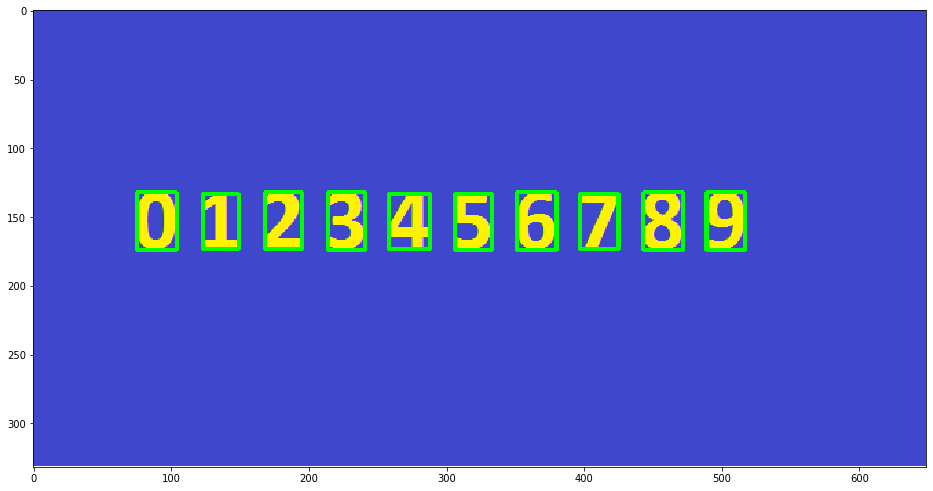

In [18]:
def load_image(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

def image_gray(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def image_bin(image_gs):
    height, width = image_gs.shape[0:2]
    image_binary = np.ndarray((height, width), dtype=np.uint8)
    ret, image_bin = cv2.threshold(image_gs, 127, 255, cv2.THRESH_BINARY)
    return image_bin

def invert(image):
    return 255-image

def display_image(image, color=False):
    if color:
        plt.imshow(image)
    else:
        plt.imshow(image, 'gray')

def dilate(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.dilate(image, kernel, iterations=1)

def erode(image):
    kernel = np.ones((3, 3)) # strukturni element 3x3 blok
    return cv2.erode(image, kernel, iterations=1)

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def select_roi(image_orig, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if area > 100 and h < 100 and h > 15 and w > 20:
            # kopirati [y:y+h+1, x:x+w+1] sa binarne slike i smestiti u novu sliku
            # oznaciti region pravougaonikom na originalnoj slici sa rectangle funkcijom
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    regions_array = sorted(regions_array, key=lambda x: x[1][0])
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=784, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann

def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

image_color = load_image('images/brojevi.png')
img = image_bin(image_gray(image_color))
img_bin = erode(dilate(img))
selected_regions, numbers = select_roi(image_color.copy(), img_bin)
display_image(selected_regions)

In [19]:
alphabet = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

inputs = prepare_for_ann(numbers)
outputs = convert_output(alphabet)
ann = create_ann(output_size=10)
ann = train_ann(ann, inputs, outputs, epochs=2000)


Training started...

Training completed...


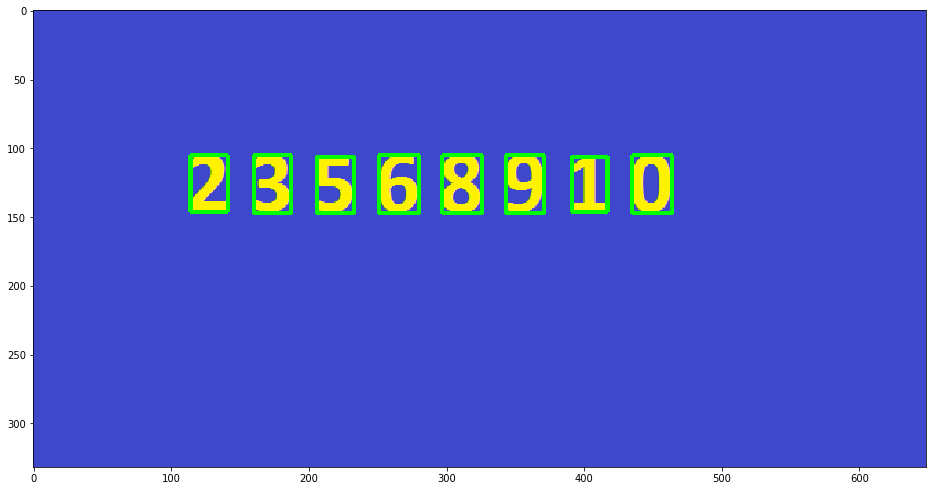

In [20]:
test_color = load_image('images/test.png')
test = image_bin(image_gray(test_color))
test_bin = erode(dilate(test))
selected_test, test_numbers = select_roi(test_color.copy(), test_bin)
display_image(selected_test)

In [21]:
test_inputs =  prepare_for_ann(test_numbers)
result = ann.predict(np.array(test_inputs, np.float32))
print(display_result(result, alphabet))

[2, 3, 5, 6, 8, 9, 1, 0]


In [22]:
def selectuh(image_orig_c, image_bin):
    contours, hierarchy = cv2.findContours(image_bin.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    sorted_regions = [] # lista sortiranih regiona po X osi
    regions_array = []
    image_orig = image_orig_c.copy()
    i = 1
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour) # koordinate i velicina granicnog pravougaonika
        area = cv2.contourArea(contour)
        if h>40 and w>40 and w<70 and h<70:
            region = image_bin[y:y+h+1, x:x+w+1]
            regions_array.append([resize_region(region), (x, y, w, h)])
            cv2.rectangle(image_orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
            i += 1
    
    #regions_array = sorted(regions_array, key=lambda x: x[1][0])
    regions_array = sorted(regions_array, key=lambda x: x[1][1])
    sorted_rectangles = [region[1] for region in regions_array]
    for i in range(len(sorted_rectangles)):
        for j in range(i+1, len(sorted_rectangles)):
            current_i = sorted_rectangles[i]
            current_j = sorted_rectangles[j]
            if current_i[1]-5 < current_j[1] and current_j[1] < current_i[1]+5 and current_j[0] < current_i[0]:
                t1 = sorted_rectangles[i]
                sorted_rectangles[i] = sorted_rectangles[j]
                sorted_rectangles[j] = t1
                t2 = regions_array[i]
                regions_array[i] = regions_array[j]
                regions_array[j] = t2
                
    sorted_regions = [region[0] for region in regions_array]
    return image_orig, sorted_regions

def resize_region(region):
    return cv2.resize(region, (28, 28), interpolation=cv2.INTER_NEAREST)

def scale_to_range(image):
    return image/255

def matrix_to_vector(image):
    return image.flatten()

def prepare_for_ann(regions):
    ready_for_ann = []
    for region in regions:
        scale = scale_to_range(region)
        ready_for_ann.append(matrix_to_vector(scale))
    return ready_for_ann

def convert_output(alphabet):
    nn_outputs = []
    for index in range(len(alphabet)):
        output = np.zeros(len(alphabet))
        output[index] = 1
        nn_outputs.append(output)
    return np.array(nn_outputs)

def create_ann(output_size):
    ann = Sequential()
    ann.add(Dense(128, input_dim=18, activation='sigmoid'))
    ann.add(Dense(output_size, activation='sigmoid'))
    return ann


def train_ann(ann, X_train, y_train, epochs):
    X_train = np.array(X_train, np.float32) # dati ulaz
    y_train = np.array(y_train, np.float32) # zeljeni izlazi na date ulaze
    
    print("\nTraining started...")
    sgd = SGD(lr=0.01, momentum=0.9)
    ann.compile(loss='mean_squared_error', optimizer=sgd)
    ann.fit(X_train, y_train, epochs=epochs, batch_size=1, verbose=0, shuffle=False)
    print("\nTraining completed...")
    return ann

def winner(output):
    return max(enumerate(output), key=lambda x: x[1])[0]

def display_result(outputs, alphabet):
    result = []
    for output in outputs:
        result.append(alphabet[winner(output)])
    return result

def result_to_numbers(result):
    numbers = [0, 0, 0, 0, 0, 0, 0]
    alpha = list(map(str,result))
    if result[-1] == 0 and result[-2] == 0:
        numbers[6] = 100
        #[1, 3, 1, 1, 4, 1, 9, 7, 7, 2, 5, 7, 4, 2, 0, 1, 0, 0]
        numbers[5] = int(alpha[-5]+alpha[-4])
        numbers[4] = result[-6]
        numbers[3] = result[-7]
        numbers[2] = result[-8]
        numbers[1] = result[-9]
        numbers[0] = int(alpha[-12]+alpha[-11]+alpha[-10])
    else:
        numbers[6] = int(alpha[-2]+alpha[-1])
        #[1, 3, 1, 1, 4, 1, 9, 7, 7, 2, 5, 7, 4, 2, 0, 5, 0]
        numbers[5] = int(alpha[-4]+alpha[-3])
        numbers[4] = result[-5]
        numbers[3] = result[-6]
        numbers[2] = result[-7]
        numbers[1] = result[-8]
        numbers[0] = int(alpha[-11]+alpha[-10]+alpha[-9])
    return numbers

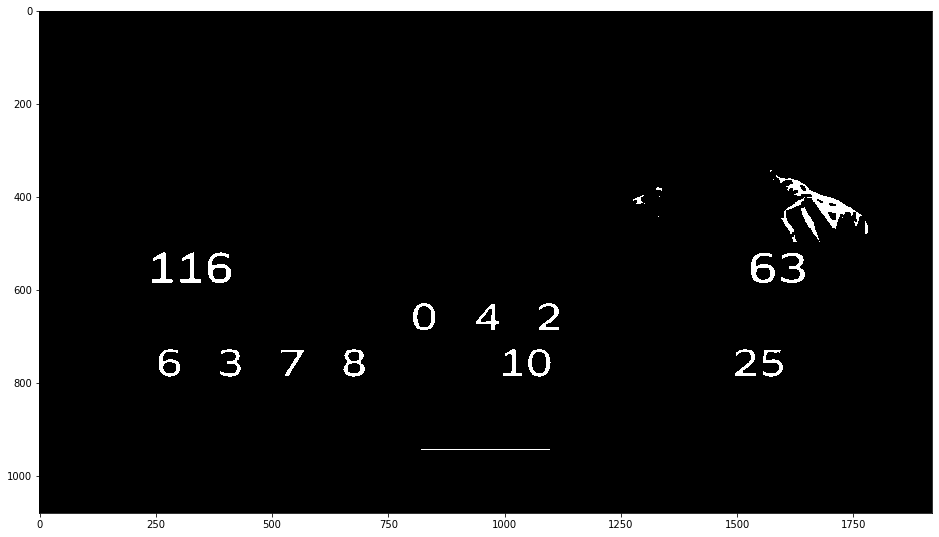

In [23]:
img = cv2.imread('images/sc122021.jpg')
img_proba = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # konvertovanje iz BGR u RGB model boja (OpenCV ucita sliku kao BGR)
plt.imshow(img_proba)  # prikazivanje slike
img_proba_gray = cv2.cvtColor(img_proba, cv2.COLOR_RGB2GRAY)
plt.imshow(img_proba_gray, 'gray')
ret, image_proba_bin = cv2.threshold(img_proba_gray, 240, 255, cv2.THRESH_BINARY) 
plt.imshow(image_proba_bin, 'gray')
kernel = np.ones((3, 3)) # strukturni element 3x3 blok
img_proba_ero = cv2.erode(image_proba_bin, kernel, iterations=3)
img_proba_open = cv2.dilate(img_proba_ero, kernel, iterations=1)
img_proba_dil = cv2.dilate(image_proba_bin, kernel, iterations=1)
img_proba_close = cv2.erode(img_proba_dil, kernel, iterations=2)
#plt.imshow(img_proba_open, 'gray')
plt.imshow(img_proba_close, 'gray')

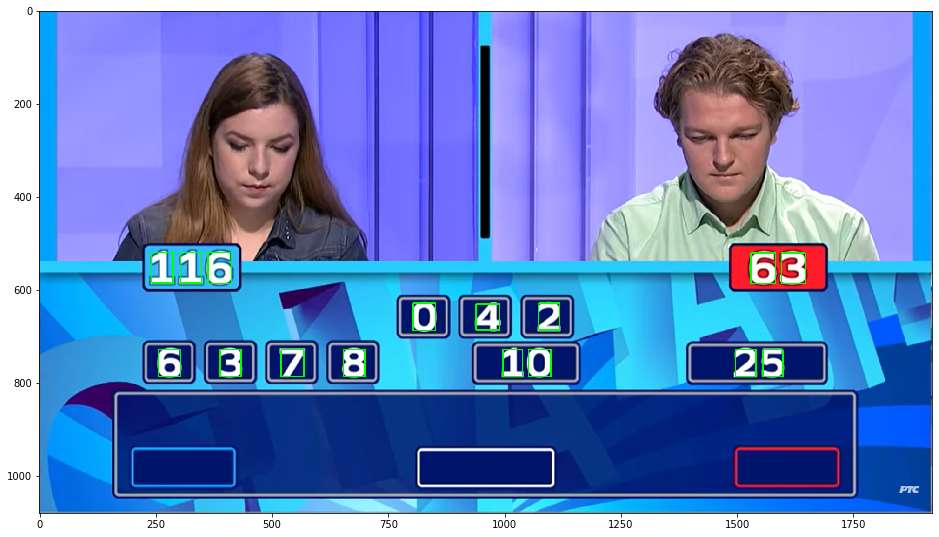

In [24]:
selected_test1, test_numbers1 = selectuh(img_proba.copy(), img_proba_close)
display_image(selected_test1)

In [25]:
test_inputs1 =  prepare_for_ann(test_numbers1)
result1 = ann.predict(np.array(test_inputs1, np.float32))
displayed_result = display_result(result1, alphabet)
print(displayed_result)
print(result_to_numbers(displayed_result))

[1, 1, 6, 6, 3, 0, 4, 2, 6, 3, 7, 8, 1, 0, 2, 5]
[42, 6, 3, 7, 8, 10, 25]
